# Time Series Modelling with Prophet and NeuralProphet

## Loading the dataset

We load the dataset of monthly average temperature of England from the UK Met Office.

In [1]:
import pandas as pd

df = pd.read_csv("https://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmean/date/England.txt", delim_whitespace=True, skiprows=5, index_col=0)
df

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,win,spr,sum,aut,ann
year,,,,,,,,,,,,,,,,,
1884,5.7,4.8,5.8,6.50,10.7,13.4,15.7,16.6,14.1,8.8,5.1,3.9,---,7.68,15.22,9.30,9.26
1885,2.3,5.3,4.1,7.20,8.4,13.5,15.7,13.4,11.8,7.0,5.4,3.1,3.78,6.55,14.21,8.08,8.11
1886,1.5,0.8,3.5,7.10,9.9,12.8,15.4,15.4,13.3,10.8,6.1,1.8,1.86,6.82,14.56,10.07,8.25
1887,1.7,3.5,3.4,6.00,9.0,14.9,16.9,15.1,11.3,6.8,4.3,2.5,2.29,6.13,15.66,7.46,7.97
1888,2.7,1.3,2.7,5.80,10.1,12.7,13.2,13.8,12.0,7.6,7.3,4.5,2.18,6.18,13.22,8.97,7.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,6.2,6.2,6.4,10.20,12.4,15.0,15.7,17.4,13.9,10.3,8.4,4.8,5.97,9.65,16.00,10.86,10.56
2021,2.9,4.8,7.0,6.20,9.9,15.3,17.5,15.8,15.8,11.8,7.3,6.1,4.16,7.71,16.22,11.61,10.06
2022,4.6,6.5,7.5,8.80,12.8,14.8,18.1,18.3,14.3,12.7,8.9,3.5,5.72,9.72,17.10,11.95,10.93


Process the dataset and convert it to the format expected by Prophet:

> The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [2]:
df = df.drop(index=2024, columns=['win','spr','sum','aut','ann'])
df = df.T.reset_index(drop=True).unstack()
df.index = pd.to_datetime(df.index.map(lambda x: f"{x[0]}-{x[1]+1}-15"))
df = df.reset_index().rename(columns={'index': 'ds', 0: 'y'})
df

,ds,y
0,1884-01-15,5.7
1,1884-02-15,4.8
2,1884-03-15,5.8
3,1884-04-15,6.5
4,1884-05-15,10.7
...,...,...
1675,2023-08-15,16.2
1676,2023-09-15,16.7
1677,2023-10-15,12.1
1678,2023-11-15,7.3


<Axes: xlabel='ds'>

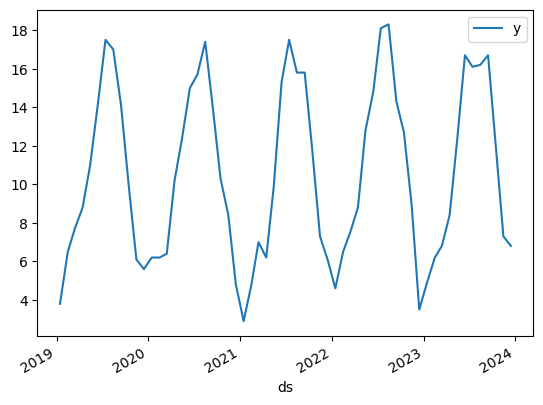

In [3]:
ws = 60  # window size (5 years)
train_df, test_df = df[:-ws], df[-ws:]
test_df.set_index('ds').plot()

## Prophet

Prophet decomposes time series into trend, seasonality, and holiday components.
$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$
where
- $g(t)$ is the trend function which models non-periodic changes.
- $s(t)$ represents periodic changes (e.g. weekly/yearly seasonality).
- $h(t)$ represents the effects of holidays.
- $\epsilon_t$ is the error term.

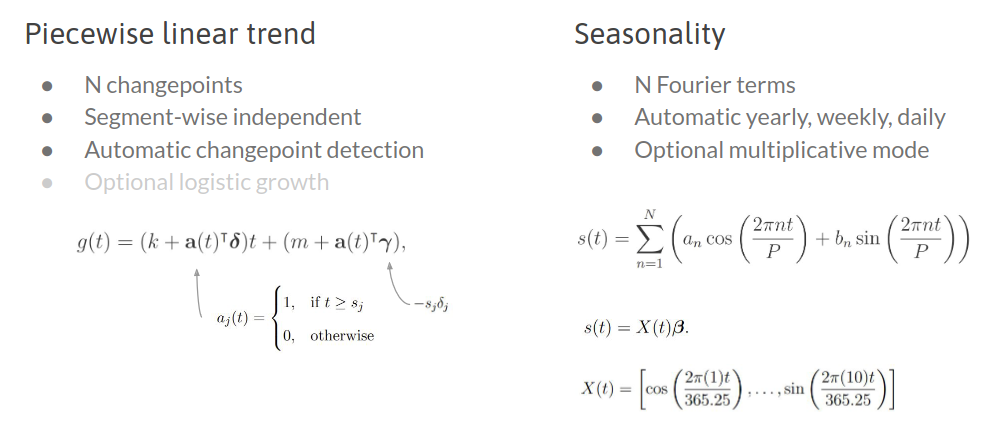

In [4]:
from prophet import Prophet

prophet = Prophet(
    n_changepoints=1,  # trend changes after global warming
    weekly_seasonality=False,
    daily_seasonality=False,
).fit(train_df)

12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
forecast = prophet.predict(df)  # use the whole dataset
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1675,2023-08-15,10.394303,15.129558,18.425543,10.394303,10.394303,6.376284,6.376284,6.376284,6.376284,6.376284,6.376284,0.0,0.0,0.0,16.770586
1676,2023-09-15,10.397206,12.829556,16.098089,10.397206,10.397206,4.144083,4.144083,4.144083,4.144083,4.144083,4.144083,0.0,0.0,0.0,14.541289
1677,2023-10-15,10.400015,9.847595,13.027843,10.400015,10.400015,0.964123,0.964123,0.964123,0.964123,0.964123,0.964123,0.0,0.0,0.0,11.364138
1678,2023-11-15,10.402918,5.820718,9.152688,10.402918,10.402918,-2.979843,-2.979843,-2.979843,-2.979843,-2.979843,-2.979843,0.0,0.0,0.0,7.423076
1679,2023-12-15,10.405728,3.963878,7.237045,10.405728,10.405728,-4.802517,-4.802517,-4.802517,-4.802517,-4.802517,-4.802517,0.0,0.0,0.0,5.603211


In [6]:
y = forecast.yhat
g = forecast.trend
s = forecast.yearly
(g + s == y).all()

True

In [7]:
from prophet.plot import plot_components_plotly

plot_components_plotly(prophet, forecast, figsize=(800, 400))

## NeuralProphet

NeuralProphet adds some terms to the Prophet model:
$$ y(t) = g(t) + s(t) + h(t) + a(t) + f(t) + l(t) + \epsilon_t $$
where
- $a(t)$ is the auto-regression component.
- $f(t)$ is the regression component for future-known exogenous variables.
- $l(t)$ is the regression component for lagged exogenous variables.

NeuralProphet introduces a neural network to model the auto-regression component:
$$ a(t) = \text{AR-Net}(y(t-1), y(t-2), \ldots, y(t-p))$$
where $p$ is *order* of auto-regression (the dimension of the input to the neural network).

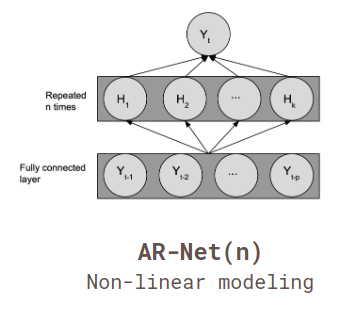

In [119]:
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

set_random_seed(123)

nprophet = NeuralProphet(
    n_changepoints=1,  # trend changes after global warming
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=6,  # AR order = 6 months
    ar_layers=[10],  # single hidden layer in the AR-Net
    ar_reg=8,  # regularization
    epochs=30,
)  # we don't use exogenous variables

set_log_level("ERROR")
nprophet.set_plotting_backend("plotly")

metrics = nprophet.fit(train_df)

Finding best initial lr:   0%|          | 0/230 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

<Axes: xlabel='epoch'>

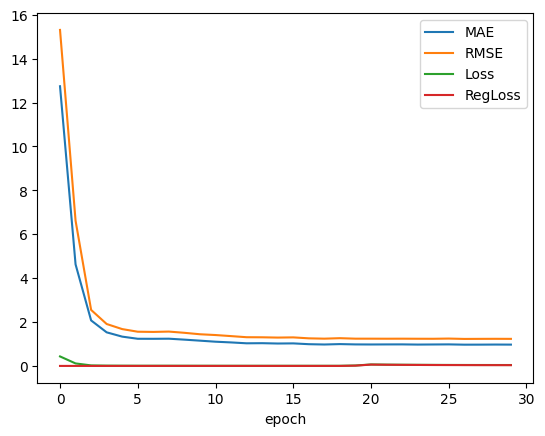

In [120]:
metrics.set_index('epoch').plot()

In [121]:
forecast1 = nprophet.predict(df)
nprophet.plot(forecast1.iloc[-ws:])

Predicting: 51it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/tcai/miniconda3/lib/python3.11/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [122]:
nprophet.plot_parameters(components=["trend", "seasonality", "autoregression"])

WARNING - (py.warnings._showwarnmsg) - /home/tcai/miniconda3/lib/python3.11/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /home/tcai/miniconda3/lib/python3.11/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /home/tcai/miniconda3/lib/python3.11/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a futu

<Axes: title={'center': 'Monthly average temperature in England (°C)'}, xlabel='ds'>

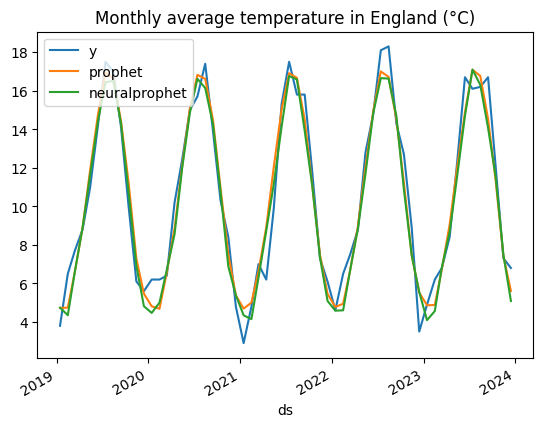

In [123]:
pred_df = test_df.assign(
    prophet=forecast['yhat'].values[-ws:],
    neuralprophet=forecast1['yhat1'].values[-ws:]
).set_index('ds')
pred_df.plot(y=['y', 'prophet', 'neuralprophet'], 
             title='Monthly average temperature in England (°C)')

## Evaluation

In [124]:
errs = pred_df - pred_df['y'].values[:, None]
eval_df = pd.DataFrame({
    'MAE': errs.abs().mean(),
    'RMSE': (errs ** 2).mean() ** 0.5,
})
eval_df

,MAE,RMSE
y,0.000000,0.000000
prophet,0.863341,1.067197
neuralprophet,0.952315,1.163761
